## Data Science Assigment for iGenius

Before going to the first problem I need to clean the data and do feature engineering which is very import part of any machinelearning project. There are 3 problems, this notebook covers first problem and data cleanup. 
### Importing all the necessary library for the project 

In [44]:
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor, cv
from sklearn.tree import DecisionTreeRegressor

## Load data
Let's load the data and take a look at the structure of the data

In [2]:
df=pd.read_csv("assignment_dataset.csv") 
print("Shape of the data: "+str(df.shape))
df.head(5)

Shape of the data: (129971, 10)


,title,variety,designation,country,province,description,price,winery,taster_name,points
0,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Vulkà Bianco,Italy,Sicily & Sardinia,"Aromas include tropical fruit, broom, brimston...",NaN,Nicosia,Kerin O’Keefe,87
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,NaN,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87


## Data Cleanup
 - I have started by identifying the columns where missing values are present

In [3]:
df.columns[df.isna().any()].tolist() 

['variety', 'designation', 'country', 'province', 'price', 'taster_name']

- creating a bar plot to see which columns has how many missing values 

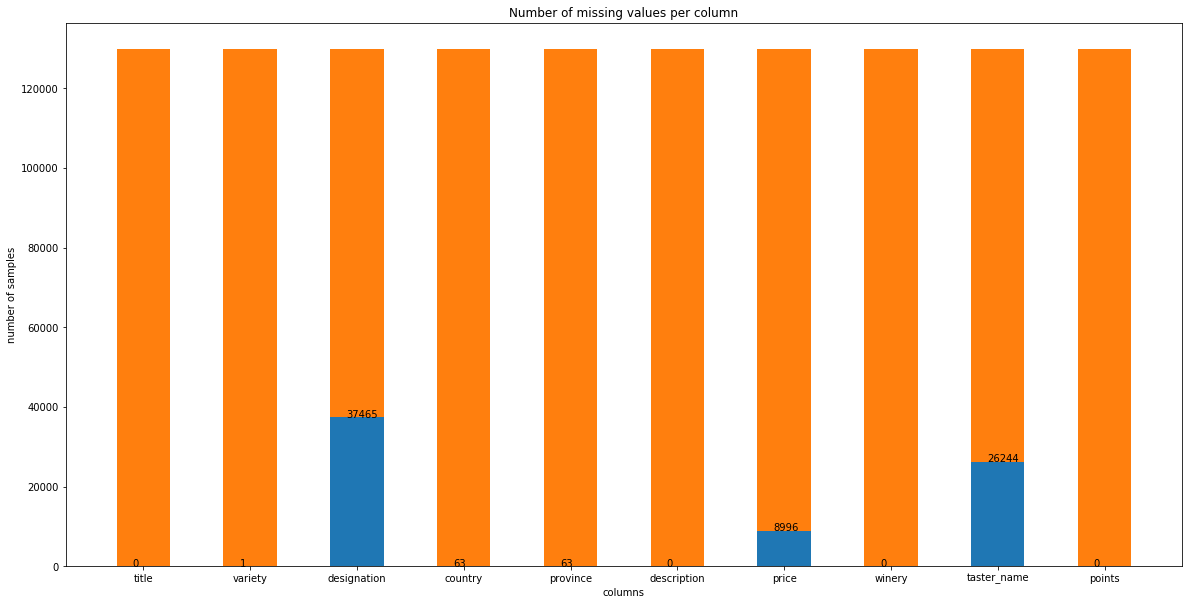

In [4]:
list_of_col=df.columns
y_1=[]
u=[]
y_2=[]
for l in list_of_col:
    y_1.append(len(df[df[l].isnull()]))
    u.append(len(df[l].unique()))
    y_2.append(len(df)-len(df[df[l].isnull()]))

y_pos = np.arange(len(list_of_col))
plt.figure(figsize=(20,10))
plt.bar(y_pos, y_1, 0.50)
plt.bar(y_pos, y_2, 0.50,bottom=y_1)
plt.xticks(y_pos, list_of_col)
plt.ylabel('number of samples')
plt.xlabel('columns')
plt.title('Number of missing values per column')
for i, v in enumerate(y_1):
    plt.text(y_pos[i] - 0.10, v + 0.10, str(v))
plt.show()

from the above plot we can see there are lot missing values for the `designation` coloum.
  - so I am going to see some feature value for `designation` 

In [5]:
d=df.designation.fillna('unknown')
sorted(d.unique().tolist())[:10]

['#19 Phantom Limb Belmont Vineyard',
 '#50 Mon Chou',
 '#SocialSecret',
 '%@#$!',
 '&',
 "'61 Rosé",
 "'A Rina",
 "'Blend 105' Red Wine",
 "'Na Vota",
 "'P'"]

From the above list of `designation` values we can see that it's not a location as describe in the assignment 
 - so I am not going to consider the `designation` column for my model
 - I replaced the missing values with 'unknown' in case of `taster_name` and `designation`
 - I removed the samples where `country` or `province` or `variety` has missing values because number of samples missing for these columns are very small compare to total number of samples.

In [6]:
df = df[df['variety'].notna()] #remvoing the row where variety is NaN
df.designation.fillna('unknown', inplace=True) #replace missing designation replace with unknown
df.taster_name.fillna('unknown', inplace=True) #replace missing taster_name with unknown
df=df[df['country'].notna()] #remvoing the row where variety is NaN
df=df[df['province'].notna()] #remvoing the row where province is NaN

I have removed the smaples where `price` was missing and stored those samples in a different dataframe for future use

In [7]:
print("Number of samples where price is missing: "+str(len(df[df['price'].isnull()])))
price_not_present=df[df['price'].isnull()]
d_p=df[df['price'].notna()] #removing the data where price is not present 

Number of samples where price is missing: 8992


Let's check if any column still have missing values 

In [8]:
print(d_p.columns[d_p.isna().any()].tolist())

[]


before doing anything more, I have converted all text to lowercase to avoide repetition because of the case of the alphabet

 - I have decided to plot the number of unique values present in each columns 

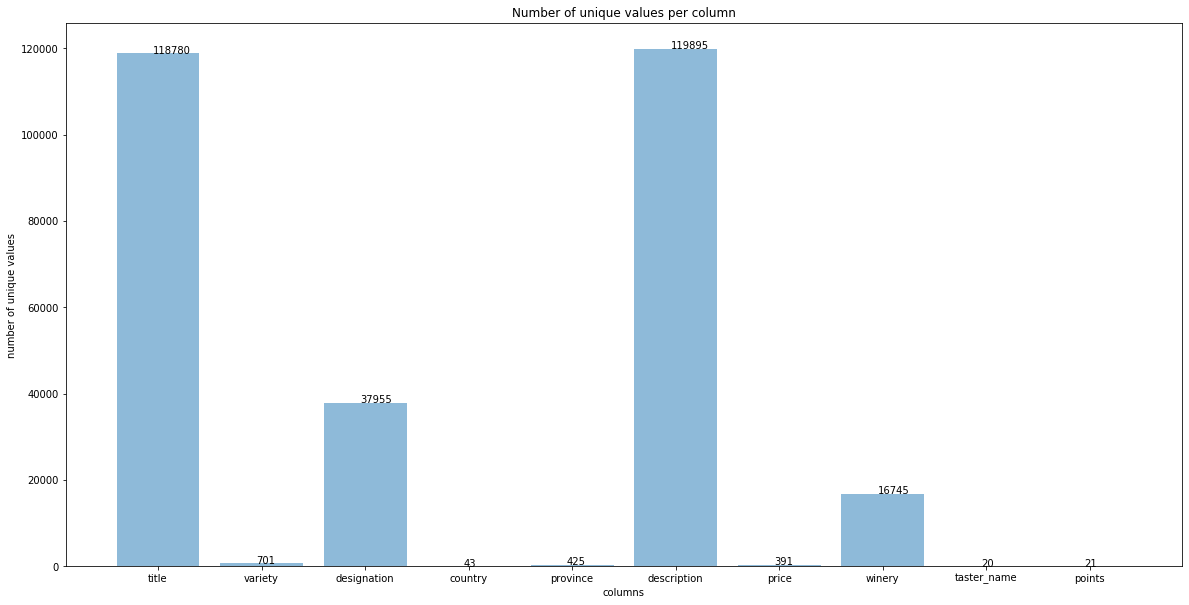

In [9]:
d_l = d_p.apply(lambda x: x.str.lower() if x.dtype=='object' else x) #lowercase everything
u=[]
for l in list_of_col:
    u.append(len(df[l].unique()))
u_pos = np.arange(len(list_of_col))
plt.figure(figsize=(20,10))
plt.bar(u_pos, u, align='center', alpha=0.5)
plt.xticks(u_pos, list_of_col)
plt.ylabel('number of unique values')
plt.xlabel('columns')
plt.title('Number of unique values per column')
for i, v in enumerate(u):
    plt.text(u_pos[i] - 0.05, v + 0.05, str(v))
plt.show()

From the plot above you can a better understanding of the data.
 - Almost every sample in the data has unique `title`
 - Number of unique `designation` also very high 
 - Almost all the samples has unique `descriptions`
 - Also number of unique `winery` is very large 
 - there are very limited number of `taster_name` present 
 - even though the `points` are given withing 0 to 100, but it more less range between 20 to 100
 - Other columns looks fine 

In [10]:
d_l.reset_index(drop=True, inplace=True) # reset the index of the dataframe after removing rows from the middle 

## Bar charts and categorical data

It's a good way to see the data and analyze the data so I can make better decision 

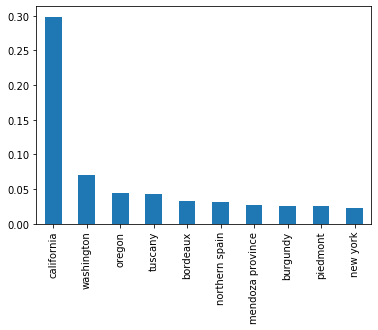

In [11]:
(d_l['province'].value_counts().head(10) / len(d_l)).plot.bar()

From the plot of the province we can see that california produce more wine than any other province. This plot shows in relative proportion. California produces almost a third of wines.

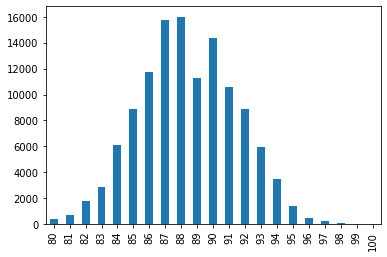

In [12]:
d_l['points'].value_counts().sort_index().plot.bar()

As you can see, every wine is allotted an overall score between 80 and 100. Where higher number means better. Lowest score is 80 and best score received by a wine is 100

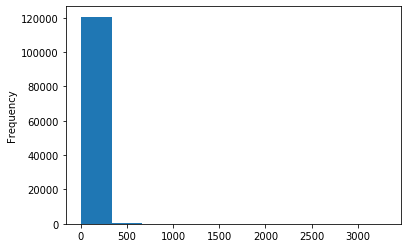

In [13]:
d_l['price'].plot.hist()

Shows that most of the wines cost less than 300. So let focus on that price range and plot the histogram again

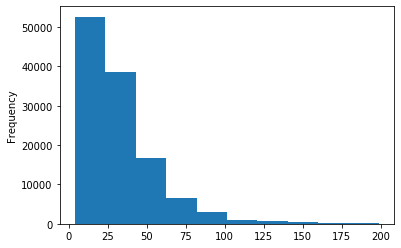

In [14]:
d_l[d_l['price'] < 200]['price'].plot.hist()

This plot shows us better price distribution of wines. Most of the wines cost less than 25. We can make this a classification problem also by creating different buckets for price.

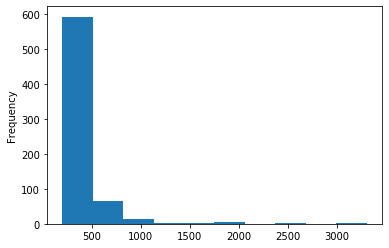

In [15]:
d_l[d_l['price'] > 200]['price'].plot.hist()

There are very less wine which cost more than 200. By the histogram of the price we get a better idea about the price distribution in our dataset 

Question ask to predict `price` of the wine from the given information about the wine. The problem is a regression problem where model will learn a function from the training data and it will predict price for a new sample. 
First thing I can see: We have many categorical features so there are couple of methods I can follow to prepare this data for regression. 
 - first thing I have tried to use basic regression model provide by sklearn
 - So I converted the categorical features by one-hot encoding, also tried to use label encoding 
 - As I have noticed after one-hot encoding my feature vector became too large
 - Large feature vector create memory problem to run Randomforest or support vector mechine
 - I have decide to use only few feature as input like `variety`, `country`, `taster_name`, and `point`

In [66]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res=dummies
    return(res)
varieties=encode_and_bind(d_l,'variety')
countries=encode_and_bind(d_l, 'country')
# proviences=encode_and_bind(d_l, 'province')
# wineries=encode_and_bind(d_l,'winery')
taster=encode_and_bind(d_l,'taster_name')
p = d_l['points']/100 #scaling 
x=pd.concat([p, countries, varieties, taster], axis=1, ignore_index=True)

# def label_encode(dataframe,field): 
#     le = preprocessing.LabelEncoder()
#     le.fit(d_l[field])
#     return le.transform(d_l[field]).reshape(-1,1)
# varieties=label_encode(d_l,'variety')
# countries=label_encode(d_l, 'country')
# proviences=label_encode(d_l, 'province')
# # wineries=label_encode(d_l,'winery')
# taster_names=label_encode(d_l,'taster_name')
# p = d_l['points'] 
# x=np.column_stack((varieties,countries,p))


## Dataset preparation

- I have reshaped the price to create label 
- then I have created training test split with fuction from sklearn 
- I have splited the data in 80:20, 80% sample for training and 20% for test 

In [67]:
y=d_l['price'].values.reshape(-1,1) #reshaped the price to create labels
X_train, X_test, y_train, y_test = train_test_split(x.values, y, test_size=0.2, random_state=42)

## Model training

- First I have tried the RandomForestRegressor from sklearn library. I have tried RandomForest because randomforest geberally work good because it does random sampling of the data and create many decision tree and result is avg of all decision tree. I have calculated mean absolute error for test set to evaluate model performance. 

In [35]:
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X_train, y_train)

C:\Users\ARNAB\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [36]:
predictions = regr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 25.46 degrees.


We can see that result of randomforest model. Where mean absolute error is 25.46 degrees which is not so good so we will try some other models 

## Catboost 

I have decided to use the [catboost library](https://catboost.ai/docs/concepts/python-reference_catboostregressor.html) because of it's performance 

- I have prepared the data and created an array to input index of the categorical features 
- We have created train, test and validation set with 70%, 15%, and 15% samples respectively 

In [73]:
y=d_l['price'].values.reshape(-1,1)
X=d_l[['variety', 'designation', 'country', 'province', 'winery',
       'taster_name', 'points']]
print(X.columns)
categorical_features_indices =[0,1,2,3,4,5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, 
                                                    random_state=42)

Index(['variety', 'designation', 'country', 'province', 'winery',
       'taster_name', 'points'],
      dtype='object')


In [74]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=100,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model

In [ ]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

In [ ]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

## AdaBoostRegressor

[AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) model is provided by scikit learn. This is based on decision tree regressor. It begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

rng = np.random.RandomState(1)
regr = AdaBoostRegressor( DecisionTreeRegressor(max_depth=200, random_state=42),n_estimators=500, loss='square', random_state=42)
regr.fit(X_train, y_train)

In [69]:
print("RMSE on training data: "+ regr.score(X_train, y_train).astype(str))
print("RMSE on test data: "+ regr.score(X_test, y_test).astype(str))

RMSE on training data: 0.4377381038297395
RMSE on test data: 0.24841476445555277


From the result we can see that RMSE error for training set is 0.43 and test set is 0.28. which is better than the previous models but still not good 

In the I have saved the processed dataframe as csv so that I can use it for second question

In [38]:
d_l.to_csv('dataprocessed.csv',index=False)